In [231]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import joblib
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import ADASYN
from sklearn.preprocessing import RobustScaler, StandardScaler

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout
import warnings
warnings.filterwarnings("ignore")


In [185]:
df = pd.read_csv('dataset/data.csv')

In [186]:
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [187]:
df.shape

(6362620, 11)

In [188]:
df.dtypes

step                int64
type               object
amount            float64
nameOrig           object
oldbalanceOrg     float64
newbalanceOrig    float64
nameDest           object
oldbalanceDest    float64
newbalanceDest    float64
isFraud             int64
isFlaggedFraud      int64
dtype: object

1. PREPROCESSING

In [189]:
df.isna().sum()/df.shape[0]*100

step              0.0
type              0.0
amount            0.0
nameOrig          0.0
oldbalanceOrg     0.0
newbalanceOrig    0.0
nameDest          0.0
oldbalanceDest    0.0
newbalanceDest    0.0
isFraud           0.0
isFlaggedFraud    0.0
dtype: float64

In [190]:
df.duplicated().sum()

0

In [191]:
df = df.drop_duplicates()
df.duplicated().sum()

0

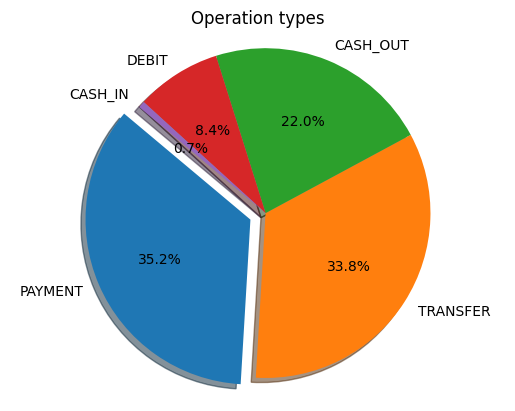

In [192]:
labels = df['type'].unique()
values = df['type'].value_counts()
explode = [0 for value in range(len(values))]
explode[0] = 0.1
plt.pie(values, explode=explode, labels=labels,
        autopct='%1.1f%%', shadow=True, startangle=140)
plt.axis('equal') 
plt.title('Operation types')
plt.show()

In [193]:
df['nameOrig'].nunique(), df['nameDest'].nunique()

(6353307, 2722362)

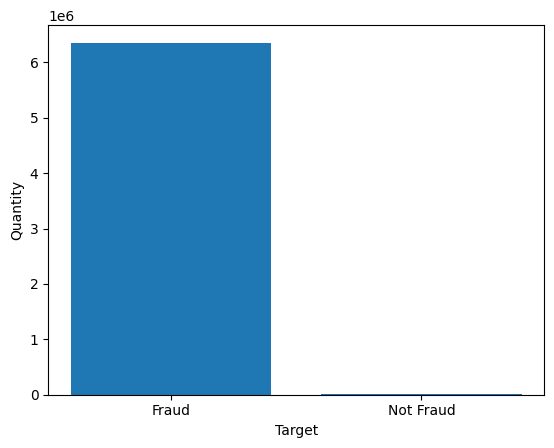

0    99.870918
1     0.129082
Name: isFraud, dtype: float64

In [194]:
labels = ['Fraud', 'Not Fraud']
values = df['isFraud'].value_counts()
plt.bar(labels, values)

plt.xlabel('Target')
plt.ylabel('Quantity')

plt.show()
df['isFraud'].value_counts(normalize=True)*100

In [195]:
df['From'] = df['oldbalanceOrg'] - df['newbalanceOrig']
df['To'] = df['oldbalanceDest'] - df['newbalanceDest']

In [196]:
df = df.drop(['oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest', 'nameOrig', 'nameDest'], axis=1)

In [197]:
df.head()

,step,type,amount,isFraud,isFlaggedFraud,From,To
0,1,PAYMENT,9839.64,0,0,9839.64,0.0
1,1,PAYMENT,1864.28,0,0,1864.28,0.0
2,1,TRANSFER,181.00,1,0,181.00,0.0
3,1,CASH_OUT,181.00,1,0,181.00,21182.0
4,1,PAYMENT,11668.14,0,0,11668.14,0.0


In [198]:
obj_to_num = {val:i for i, val in enumerate(df['type'].unique())}
obj_to_num

{'PAYMENT': 0, 'TRANSFER': 1, 'CASH_OUT': 2, 'DEBIT': 3, 'CASH_IN': 4}

In [199]:
df['type'] = df['type'].map(obj_to_num)
df['type']

0          0
1          0
2          1
3          2
4          0
          ..
6362615    2
6362616    1
6362617    2
6362618    1
6362619    2
Name: type, Length: 6362620, dtype: int64

In [200]:
not_fraud_sample = df[df['isFraud']==0].sample(df[df['isFraud']==1].shape[0])

In [201]:
df_undersampled = pd.concat([not_fraud_sample, df[df['isFraud']==1]], axis=0)
df_undersampled['isFraud'].value_counts()

0    8213
1    8213
Name: isFraud, dtype: int64

In [202]:
x = df_undersampled.drop('isFraud', axis=1)
Y = df_undersampled['isFraud']

In [203]:
x_train_under, x_test_under, Y_train_under, Y_test_under = train_test_split(x, Y, test_size=0.2, random_state=42)

In [204]:
standart_scaler = StandardScaler()
standart_scaler.fit(x_train_under)
x_train_under = standart_scaler.transform(x_train_under)
x_test_under = standart_scaler.transform(x_test_under)

print(x_train_under.shape, Y_train_under.shape)
print(x_test_under.shape, Y_test_under.shape)

(13140, 6) (13140,)
(3286, 6) (3286,)


In [205]:
df_undersampled.shape

(16426, 7)

In [206]:
x = df.drop('isFraud', axis=1)
Y = df['isFraud']

In [207]:
scaler = RobustScaler()
x_scaled = scaler.fit_transform(x)

In [208]:
adasyn = ADASYN()
X_resampled, y_resampled = adasyn.fit_resample(x_scaled, Y)

In [209]:
df_oversampled = pd.DataFrame(X_resampled, columns=x.columns)
df_oversampled['isFraud'] = y_resampled

In [210]:
df_oversampled['isFraud'].value_counts()

1    6354425
0    6354407
Name: isFraud, dtype: int64

In [211]:
df_oversampled = df_oversampled.sample(85000)

In [212]:
x = df_oversampled.drop('isFraud', axis=1)
Y = df_oversampled['isFraud']
x_train_over, x_test_over, Y_train_over, Y_test_over = train_test_split(x, Y, test_size=0.2, random_state=42)

2. MODELS

In [213]:
models = [SVC(), LogisticRegression(), DecisionTreeClassifier(),
    XGBClassifier(), RandomForestClassifier(),KNeighborsClassifier()]
labels = ['SVC', 'LogisticRegression', 'DecisionTreeClassifier', 'XGBClassifier', 'RandomForestClassifier', 
          'KNeighborsClassifier']
reports_over = {}
reports_under = {}

In [214]:
for i in range(len(models)):
    print(f'Model #{i+1}: {models[i]}, oversampled df')
    models[i].fit(x_train_over, Y_train_over)
    Y_pred = models[i].predict(x_test_over)
    report = classification_report(Y_test_over, Y_pred, output_dict=True)
    reports_over[f'{labels[i]}'] = report
    print(report)
    joblib.dump(models[i], f'models/{labels[i]}_model_oversampled.joblib')
    print(f'Model saved models/{labels[i]}_model_oversampled.joblib \n\n')
    
    print(f'Model #{i+1}: {models[i]}, undersampled df')
    models[i].fit(x_train_under, Y_train_under)
    Y_pred = models[i].predict(x_test_under)
    report = classification_report(Y_test_under, Y_pred, output_dict=True)
    reports_under[f'{labels[i]}'] = report
    print(report)
    joblib.dump(models[i], f'models/{labels[i]}_model_undersampled.joblib')
    print(f'Model saved models/{labels[i]}_model_undersampled.joblib \n\n')


Model #1: SVC(), oversampled df
{'0': {'precision': 0.89818310523832, 'recall': 0.9053395171839695, 'f1-score': 0.9017471128220313, 'support': 8409}, '1': {'precision': 0.9066166119192868, 'recall': 0.8995460365498777, 'f1-score': 0.9030674846625767, 'support': 8591}, 'accuracy': 0.9024117647058824, 'macro avg': {'precision': 0.9023998585788033, 'recall': 0.9024427768669236, 'f1-score': 0.902407298742304, 'support': 17000}, 'weighted avg': {'precision': 0.9024450026439781, 'recall': 0.9024117647058824, 'f1-score': 0.9024143666150976, 'support': 17000}}
Model saved models/SVC_model_oversampled.joblib 


Model #1: SVC(), undersampled df
{'0': {'precision': 0.9261627906976744, 'recall': 0.9660400242571255, 'f1-score': 0.9456812110418523, 'support': 1649}, '1': {'precision': 0.9642401021711366, 'recall': 0.9224190592547342, 'f1-score': 0.9428660630658758, 'support': 1637}, 'accuracy': 0.9443091905051735, 'macro avg': {'precision': 0.9452014464344055, 'recall': 0.9442295417559299, 'f1-score

In [215]:
reports_over

{'SVC': {'0': {'precision': 0.89818310523832,
   'recall': 0.9053395171839695,
   'f1-score': 0.9017471128220313,
   'support': 8409},
  '1': {'precision': 0.9066166119192868,
   'recall': 0.8995460365498777,
   'f1-score': 0.9030674846625767,
   'support': 8591},
  'accuracy': 0.9024117647058824,
  'macro avg': {'precision': 0.9023998585788033,
   'recall': 0.9024427768669236,
   'f1-score': 0.902407298742304,
   'support': 17000},
  'weighted avg': {'precision': 0.9024450026439781,
   'recall': 0.9024117647058824,
   'f1-score': 0.9024143666150976,
   'support': 17000}},
 'LogisticRegression': {'0': {'precision': 0.8750865051903114,
   'recall': 0.902247591865858,
   'f1-score': 0.8884595116810117,
   'support': 8409},
  '1': {'precision': 0.9013205282112845,
   'recall': 0.8739378419275986,
   'f1-score': 0.8874180013001596,
   'support': 8591},
  'accuracy': 0.8879411764705882,
  'macro avg': {'precision': 0.888203516700798,
   'recall': 0.8880927168967283,
   'f1-score': 0.8879387

In [216]:
def classifiers_comparison(data, title):
    classifiers = list(data.keys())
    metrics = ['accuracy', 'f1-score', 'precision', 'recall']

    x = np.arange(len(classifiers))
    width = 0.2

    fig, ax = plt.subplots(figsize=(12, 8))

    for i, metric in enumerate(metrics):
        if metric == 'accuracy':
            values = [data[c][metric] for c in classifiers]
        else:
            values = [data[c]['weighted avg'][metric] for c in classifiers]
        ax.bar(x + i*width, values, width, label=metric)

    ax.set_xlabel('Classifiers')
    ax.set_ylabel('Scores')
    ax.set_title(title)
    ax.set_xticks(x + width)
    ax.set_xticklabels(classifiers)
    ax.legend()

    plt.xticks(rotation=45)
    plt.tight_layout()

    plt.show()


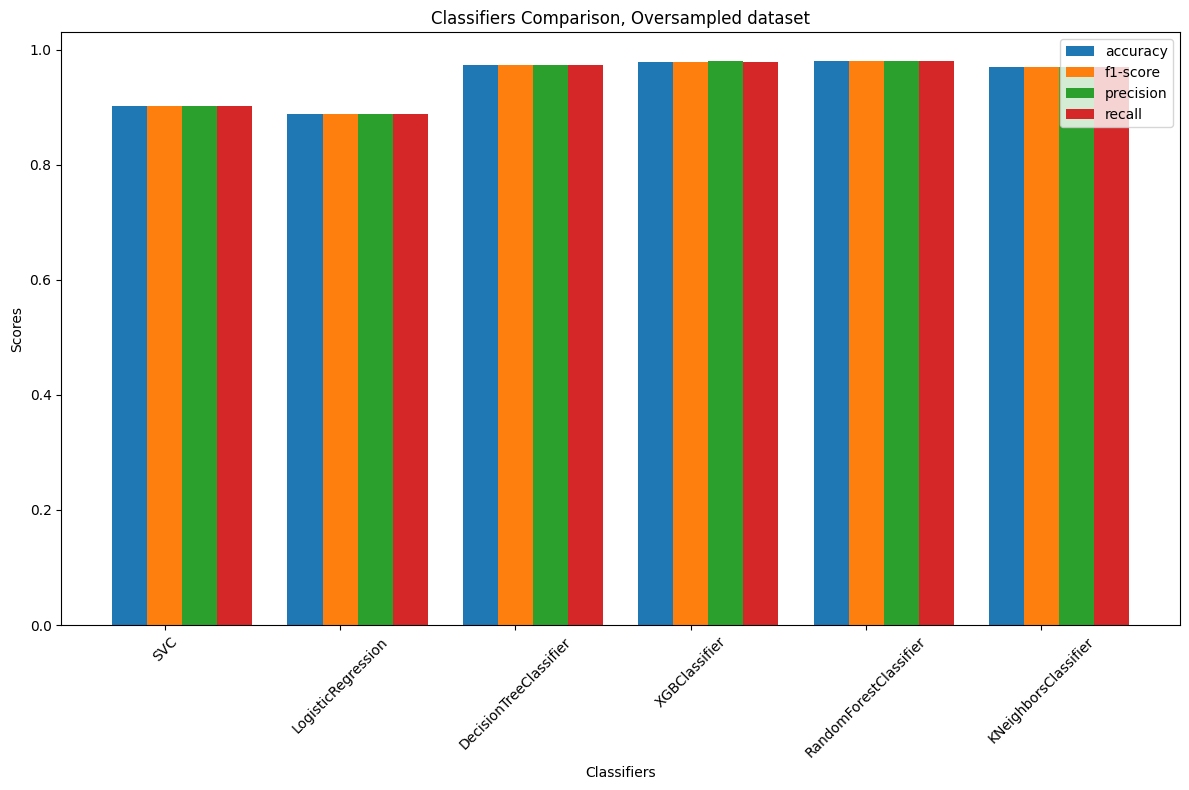

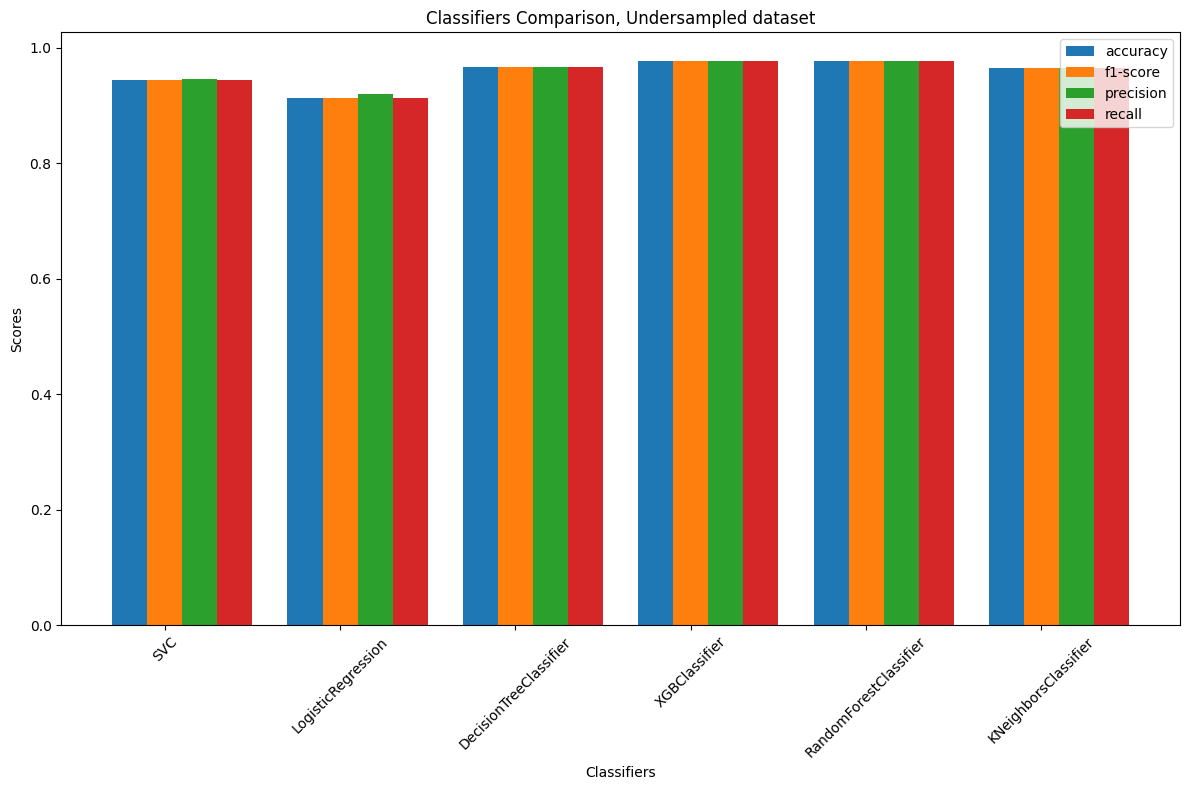

In [217]:
classifiers_comparison(reports_over, 'Classifiers Comparison, Oversampled dataset')
classifiers_comparison(reports_under, 'Classifiers Comparison, Undersampled dataset') 

In [218]:
model = Sequential()
model.add(Dense(64, input_dim=x_train_over.shape[1], activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(32, activation='relu')) 
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

In [219]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [220]:
history = model.fit(x_train_over, Y_train_over, 
                    epochs=20,
                    validation_data=(x_test_over, Y_test_over))

Epoch 1/20
2125/2125 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.8481 - loss: 0.4060 - val_accuracy: 0.9446 - val_loss: 0.1751
Epoch 2/20
2125/2125 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.9379 - loss: 0.2022 - val_accuracy: 0.9611 - val_loss: 0.1254
Epoch 3/20
2125/2125 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.9510 - loss: 0.1601 - val_accuracy: 0.9641 - val_loss: 0.1204
Epoch 4/20
2125/2125 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.9550 - loss: 0.1483 - val_accuracy: 0.9655 - val_loss: 0.1131
Epoch 5/20
2125/2125 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.9547 - loss: 0.1445 - val_accuracy: 0.9668 - val_loss: 0.1105
Epoch 6/20
2125/2125 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.9571 - loss: 0.1413 - val_accuracy: 0.9657 - val_loss: 0.1105
Epoch 7/20
2125/2125 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.9591 - loss: 0.1347 - val_accuracy: 0.9681 - val_loss: 0.1054
Epoch 8/20
2125/2125 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - accuracy: 0.9601 - loss: 0.1339 - 

In [221]:
model.save('models/keras_model_over.keras')

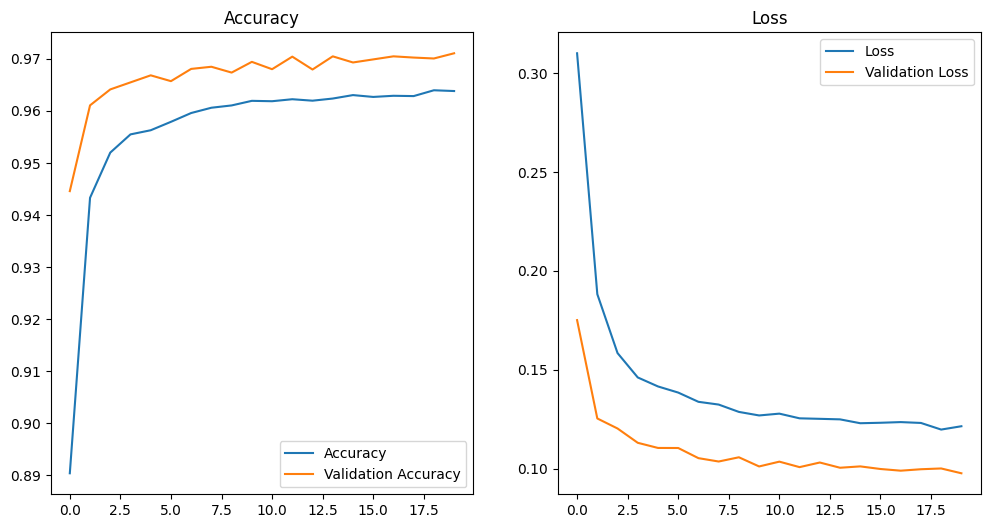

In [222]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(12,6))
plt.subplot(121)
plt.plot(range(len(acc)), acc, label='Accuracy')
plt.plot(range(len(acc)), val_acc, label='Validation Accuracy')
plt.title('Accuracy')
plt.legend()

plt.subplot(122)
plt.plot(range(len(loss)), loss, label='Loss')
plt.plot(range(len(loss)), val_loss, label='Validation Loss')
plt.title('Loss')
plt.legend()

In [223]:
history = model.fit(x_train_under, Y_train_under, 
                    epochs=20,
                    validation_data=(x_test_under, Y_test_under))

Epoch 1/20
411/411 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7410 - loss: 2.9219 - val_accuracy: 0.8445 - val_loss: 0.2894
Epoch 2/20
411/411 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8110 - loss: 0.3902 - val_accuracy: 0.8734 - val_loss: 0.2564
Epoch 3/20
411/411 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8247 - loss: 0.3423 - val_accuracy: 0.8923 - val_loss: 0.2456
Epoch 4/20
411/411 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8406 - loss: 0.3101 - val_accuracy: 0.9051 - val_loss: 0.2336
Epoch 5/20
411/411 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8532 - loss: 0.2783 - val_accuracy: 0.9121 - val_loss: 0.2204
Epoch 6/20
411/411 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8471 - loss: 0.2897 - val_accuracy: 0.9166 - val_loss: 0.2085
Epoch 7/20
411/411 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8710 - loss: 0.2592 - val_accuracy: 0.9175 - val_loss: 0.1950
Epoch 8/20
411/411 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8743 - loss: 0.2515 - val_accuracy: 0.

In [224]:
model.save('models/keras_model_under.keras')

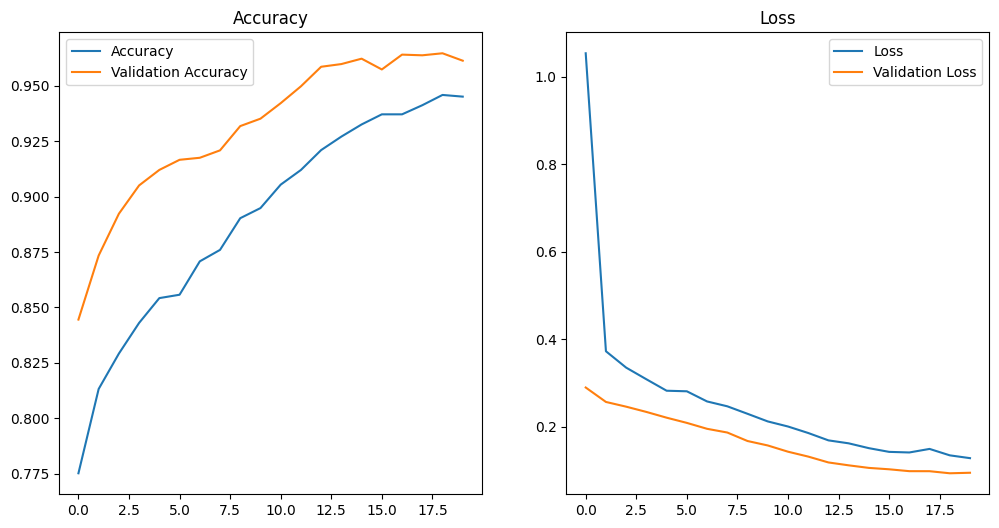

In [230]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(12,6))
plt.subplot(121)
plt.plot(range(len(acc)), acc, label='Accuracy')
plt.plot(range(len(acc)), val_acc, label='Validation Accuracy')
plt.title('Accuracy')
plt.legend()

plt.subplot(122)
plt.plot(range(len(loss)), loss, label='Loss')
plt.plot(range(len(loss)), val_loss, label='Validation Loss')
plt.title('Loss')
plt.legend()

In [226]:
res = {
    0:'Not Fraud',
    1: 'Fraud'
}

In [227]:
model_path = 'models/RandomForestClassifier_model_oversampled.joblib'
if 'joblib' == model_path.split('.')[1]:
    model = joblib.load(model_path)
else:
    model = load_model(model_path)

In [228]:
Y_test_over = list(Y_test_over)
Y_test_under = list(Y_test_under)
if 'over' in model_path:
    pred = model.predict(x_test_over)
    pred_labels = [res[pred] for pred in Y_pred]
    for i, pred in enumerate(pred_labels):
        print(f"Test case #{i}: {pred}. True value: {res[Y_test_over[i]]}")
elif 'under' in model_path:
    pred = model.predict(x_test_under)
    pred_labels = [res[pred] for pred in Y_pred]
    for i, pred in enumerate(pred_labels):
        print(f"Test case #{i}: {pred}. True value: {res[Y_test_under[i]]}")

Test case #0: Fraud. True value: Fraud
Test case #1: Fraud. True value: Not Fraud
Test case #2: Not Fraud. True value: Not Fraud
Test case #3: Not Fraud. True value: Not Fraud
Test case #4: Not Fraud. True value: Not Fraud
Test case #5: Not Fraud. True value: Not Fraud
Test case #6: Fraud. True value: Fraud
Test case #7: Not Fraud. True value: Not Fraud
Test case #8: Fraud. True value: Fraud
Test case #9: Fraud. True value: Not Fraud
Test case #10: Not Fraud. True value: Fraud
Test case #11: Fraud. True value: Not Fraud
Test case #12: Fraud. True value: Not Fraud
Test case #13: Not Fraud. True value: Not Fraud
Test case #14: Not Fraud. True value: Not Fraud
Test case #15: Fraud. True value: Not Fraud
Test case #16: Not Fraud. True value: Fraud
Test case #17: Fraud. True value: Not Fraud
Test case #18: Fraud. True value: Not Fraud
Test case #19: Fraud. True value: Not Fraud
Test case #20: Fraud. True value: Fraud
Test case #21: Fraud. True value: Not Fraud
Test case #22: Not Fraud. True